In [1]:
import logging
import os
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch import optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchmetrics.classification import MulticlassJaccardIndex

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%matplotlib inline

In [2]:
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

# https://www.tutorialexample.com/fix-python-logging-module-not-writing-to-file-python-tutorial/
for handler in logging.root.handlers:
    logging.root.removeHandler(handler)

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s',
                   handlers=[logging.FileHandler("logfile.log", mode="a"), stream_handler])

In [3]:
class CarvanaImageMaskingChallangeDataset(Dataset):
    PATH_TO_IMGS = "/home/jurica/Desktop/projekt/Pytorch-UNet/data/imgs"
    PATH_TO_MASKS = "/home/jurica/Desktop/projekt/Pytorch-UNet/data/masks"
    IMG_EXT = ".jpg"
    MASK_EXT = "_mask.gif"
    
    def __init__(self):
        assert len(os.listdir(self.PATH_TO_IMGS)) == len(os.listdir(self.PATH_TO_MASKS))

        # Each car has exactly 16 images, each one taken at different angles.
        # Each car has a unique id and images are named according to id_01.jpg, id_02.jpg … id_16.jpg.
        self.img_ids = [os.path.splitext(img)[0] for img in os.listdir(self.PATH_TO_IMGS)]

        # black: background
        # white: car
        self.mask_values = [[0,0,0], [255,255,255]]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_name = self.img_ids[idx] + self.IMG_EXT
        img_path = os.path.join(self.PATH_TO_IMGS, img_name)

        mask_name = self.img_ids[idx] + self.MASK_EXT
        mask_path = os.path.join(self.PATH_TO_MASKS, mask_name)
        
        img_raw = Image.open(img_path)
        mask_raw = Image.open(mask_path)
        
        img, mask = self.preprocess(img_raw, mask_raw)
        
        return {"image": img, "mask": mask}

    def preprocess(self, img, mask):
        img = np.asarray(img.resize((572,572), resample=Image.Resampling.BICUBIC))
        # convert to RGB for black&white mask
        mask = np.asarray(mask.resize((388,388), resample=Image.Resampling.BICUBIC).convert("RGB")) 
        
        # create ground truth for cross entropy loss
        mask_with_classes = np.zeros((388, 388), dtype=np.int64)
        for c, mask_class_pixel_value in enumerate(self.mask_values):
            # (img == v) creates new np array, (img==v).shape == img.shape
            # (img==v)[i] -> [True, False, True] (comparing corresponding pixel components with corresponding v components)
            # (img==v).all(-1) creates new np array
            # x.all(-1) checks if every element of x along -1 (last) dimension is True
            # (img==v).all(-1).shape == (H, W)
            # in this case, check which (img==v)[i] is equal to [True, True, True] (pixel matches class v)
            
            # set pixel class to be i for every pixel in original mask image
            # if pixel values along all channels (-1) correspondingly match values of class i
            mask_with_classes[(mask == mask_class_pixel_value).all(-1)] = c
        
        # swap color axis
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2, 0, 1))

        # normalize pixels?
        #img = img / 255.0

        img_tensor = torch.tensor(img.copy()).float()
        
        mask_tensor = torch.tensor(mask_with_classes.copy()).long()
        
        return img_tensor, mask_tensor

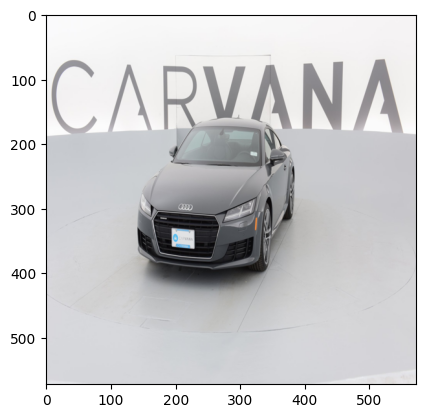

In [4]:
d = CarvanaImageMaskingChallangeDataset()
example = d[1337]["image"]
example_mask = d[1337]["mask"]

plt.imshow(example.numpy().astype(np.int32).transpose(1,2,0))

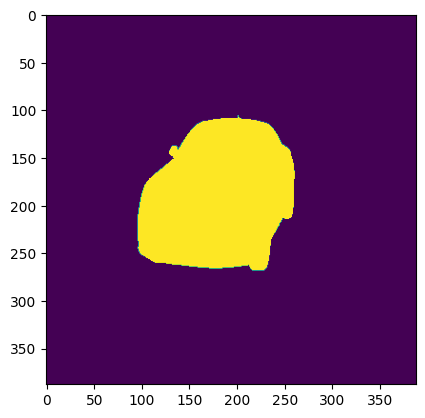

In [5]:
plt.imshow(example_mask.numpy())

In [6]:
class EncoderBlock(nn.Module):
    def __init__(self, input_volume_channels, output_volume_channels):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(input_volume_channels, output_volume_channels, kernel_size=3),
            nn.BatchNorm2d(output_volume_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(output_volume_channels, output_volume_channels, kernel_size=3),
            nn.BatchNorm2d(output_volume_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.seq(x)

class DecoderBlock(nn.Module):
    def __init__(self, input_volume_channels, output_volume_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(input_volume_channels, output_volume_channels, kernel_size=2, stride=2)
        self.double_conv = EncoderBlock(input_volume_channels, output_volume_channels)
    
    def forward(self, x, encoder_feature_map):
        deconv_ret = self.deconv(x)

        diffY = encoder_feature_map.size()[2] - deconv_ret.size()[2]
        diffX = encoder_feature_map.size()[3] - deconv_ret.size()[3]

        deconv_ret = nn.functional.pad(deconv_ret, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        concat_x = torch.cat([encoder_feature_map, deconv_ret], dim=1)

        
        
        # deconv_ret.shape[2] -> H
        #crop_fmap = torchvision.transforms.CenterCrop(deconv_ret.shape[2])(encoder_feature_map)

        # concat along "channel" dimension, dim=1 because dim=0 -> N (batch size)
        #concat_x = torch.cat((crop_fmap, deconv_ret), dim=1)

        return self.double_conv(concat_x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_block1 = EncoderBlock(3, 64)      
        self.enc_block2 = EncoderBlock(64, 128)
        self.enc_block3 = EncoderBlock(128, 256)
        self.enc_block4 = EncoderBlock(256, 512)
        self.enc_block5 = EncoderBlock(512, 1024)

        self.dec_block1 = DecoderBlock(1024, 512)
        self.dec_block2 = DecoderBlock(512, 256)
        self.dec_block3 = DecoderBlock(256, 128)
        self.dec_block4 = DecoderBlock(128, 64)

        self.final_output = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, x):
        
        enc_out1 = self.enc_block1(x)
        pooled_enc_out1 = self.max_pool(enc_out1)
        
        enc_out2 = self.enc_block2(pooled_enc_out1)
        pooled_enc_out2 = self.max_pool(enc_out2)
        
        enc_out3 = self.enc_block3(pooled_enc_out2)
        pooled_enc_out3 = self.max_pool(enc_out3)
        
        enc_out4 = self.enc_block4(pooled_enc_out3)
        pooled_enc_out4 = self.max_pool(enc_out4)
        
        enc_out5 = self.enc_block5(pooled_enc_out4)

        dec_out1 = self.dec_block1(enc_out5, enc_out4)
        dec_out2 = self.dec_block2(dec_out1, enc_out3)
        dec_out3 = self.dec_block3(dec_out2, enc_out2)
        dec_out4 = self.dec_block4(dec_out3, enc_out1)

        return self.final_output(dec_out4)


In [7]:
def train_model(model, device, epochs, batch_size, learning_rate, weight_decay, momentum, val_percent):
    dataset = CarvanaImageMaskingChallangeDataset()

    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], torch.Generator().manual_seed(1337))

    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=False)

    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, fused=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5) # maximize IOU
    criterion = nn.CrossEntropyLoss() # default reduction: the weighted mean of the output of LogSoftmax is taken

    logging.info(
        f"""Starting training:
        Epochs:              {epochs}
        Batch size:          {batch_size}

        Training set size:   {n_train}
        Validation set size: {n_val}
        
        Learning rate:       {learning_rate}
        Weight decay:        {weight_decay}
        Momentum:            {momentum}
        """
    )
    
    global_step = 0
    for epoch in range(1, epochs+1):
        model.train() # for BatchNorm

        with tqdm(total=n_train, desc=f"Epoch {epoch}/{epochs}", unit="img") as progress:
            for batch in train_loader:
                images = batch["image"].to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                masks = batch["mask"].to(device=device, dtype=torch.long)

                masks_pred = model(images)

                masks_pred = nn.functional.interpolate(masks_pred, size=388, mode="bicubic")
                
                loss = criterion(masks_pred, masks)
                
                iou = MulticlassJaccardIndex(num_classes=2, average="macro").to(device=device) # Calculate statistics for each label and average them
                loss += iou(masks_pred, masks).item()
                
                optimizer.zero_grad(set_to_none=True)

                loss.backward()

                optimizer.step()

                # update number of remaining images
                progress.update(images.shape[0])
                progress.set_postfix(**{"loss (batch)" : loss.item()})
                global_step += 1
                
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score = 0
                        #with torch.inference_mode(): # disable gradient calculation
                        model.eval() # for BatchNorm
                        
                        iou_score = 0
                        num_val_batches = len(val_loader)
                        
                        for batch in tqdm(val_loader, total=num_val_batches, desc="Validation", unit="batch", position=0, leave=True):
                            images = batch["image"].to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                            masks = batch["mask"].to(device=device, dtype=torch.long)

                            masks_pred = model(images)
                            masks_pred = nn.functional.interpolate(masks_pred, size=388, mode="bicubic")

                            iou2 = MulticlassJaccardIndex(num_classes=2, average="macro").to(device=device) # Calculate statistics for each label and average them
                            iou_score += iou2(masks_pred, masks).item()
                        
                        model.train()
                        val_score = iou_score / max(num_val_batches, 1)
                        logging.info(f"IOU score: {val_score}")
                        scheduler.step(val_score)
                        
        
        state_dict = model.state_dict()
        torch.save(state_dict, "/home/jurica/Desktop/projekt/pokusaj/checkpoints/checkpoint_epoch{}.pth".format(epoch))
        logging.info(f"Checkpoint {epoch} saved!")
                
                

In [8]:
#torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available() == True

model = UNet()
model = model.to(device=device, memory_format=torch.channels_last)

#state_dict = torch.load(args.load, map_location=device)
#del state_dict['mask_values']
#model.load_state_dict(state_dict)


train_model(
    model=model,
    device=device,
    epochs=2,
    batch_size=1,
    learning_rate=1e-5,
    weight_decay=1e-8,
    momentum=0.999,
    val_percent=0.1
)




INFO: Starting training:
        Epochs:              2
        Batch size:          1

        Training set size:   4565
        Validation set size: 507
        
        Learning rate:       1e-05
        Weight decay:        1e-08
        Momentum:            0.999
        
Validation: 100%|████████████████████████████████████████████████████████| 507/507 [00:35<00:00, 14.34batch/s]
INFO: IOU score: 0.8486907047750447
Validation: 100%|████████████████████████████████████████████████████████| 507/507 [00:35<00:00, 14.43batch/s]
INFO: IOU score: 0.9521366170877535
Validation: 100%|████████████████████████████████████████████████████████| 507/507 [00:35<00:00, 14.43batch/s]
INFO: IOU score: 0.9371453094529447
Validation: 100%|████████████████████████████████████████████████████████| 507/507 [00:35<00:00, 14.43batch/s]
INFO: IOU score: 0.8462926633729502
Validation: 100%|████████████████████████████████████████████████████████| 507/507 [00:39<00:00, 12.86batch/s]
INFO: IOU score: 0.6830

In [157]:
def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)

In [158]:
def predict(model, device, image_path, out_thresh=0.5):
    #test_image = "/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/test.jpg"
    img_raw = Image.open(image_path)
    img = np.asarray(img_raw.resize((572,572), resample=Image.Resampling.BICUBIC))
    img_n = img.transpose((2, 0, 1))
    img_n = img_n / 255.0
    img_tensor = torch.tensor(img_n.copy()).float()
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device=device, dtype=torch.float32)
    
    mask = None
    with torch.inference_mode(): # disable gradient calculation
        output = model(img_tensor).cpu()
        output = nn.functional.interpolate(output, size=572, mode="bicubic")
        mask = torch.sigmoid(output) > 0.5
        mask = mask[0].long().squeeze().numpy()
    
    
    predicted = np.asarray(mask_to_image(mask, [0,1]))
    return img, predicted

In [159]:
# test image from dataset not used during training
ground_truth = Image.open("/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_mask/0cdf5b5d0ce1_04_mask.gif")
ground_truth = np.asarray(ground_truth.resize((572,572), resample=Image.Resampling.BICUBIC))

img, predicted = predict(model, device, "/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/0cdf5b5d0ce1_04.jpg")

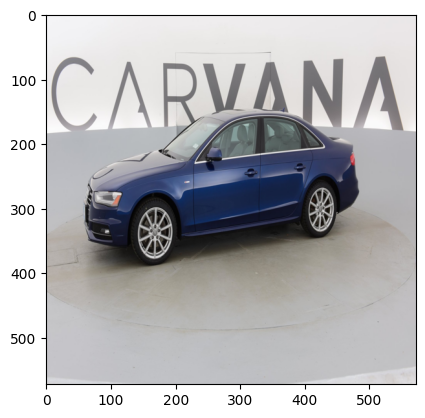

In [160]:
plt.imshow(img)

IOU:99.12%


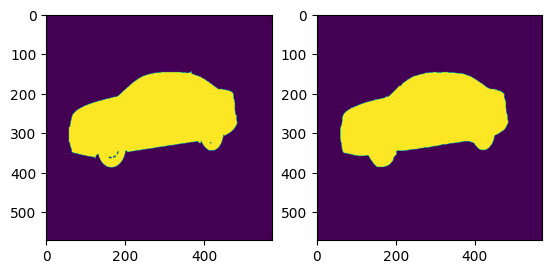

In [161]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(ground_truth)
axarr[1].imshow(predicted)

iou = MulticlassJaccardIndex(num_classes=2, average="macro").to(device=device)
iou_score = iou(torch.tensor(predicted).to(device=device), torch.tensor(ground_truth).to(device=device)).item()
print(f"IOU:{round(iou_score*100, 2)}%")

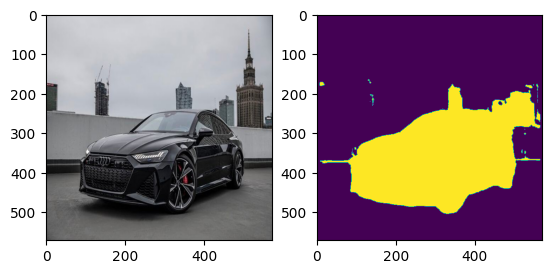

In [162]:
# image that is not from dataset
img, predicted = predict(model, device, "/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/test6.jpg")

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(predicted)

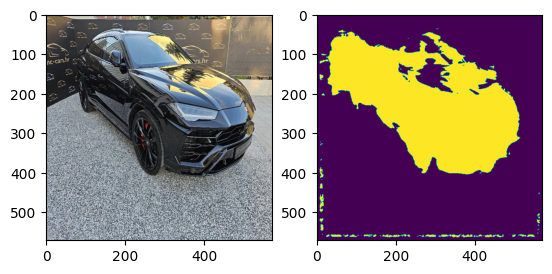

In [163]:
# image that is not from dataset
img, predicted = predict(model, device, "/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/test.jpg")

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(predicted)

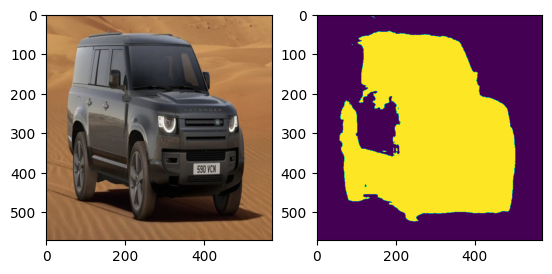

In [164]:
# image that is not from dataset
img, predicted = predict(model, device, "/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/test4.jpg")

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(predicted)

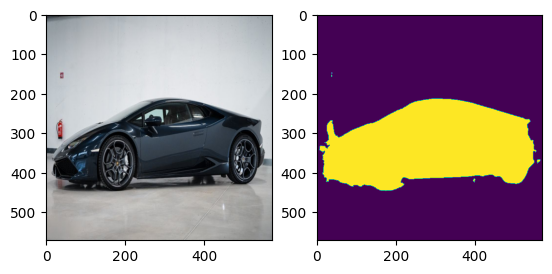

In [165]:
# image that is not from dataset
img, predicted = predict(model, device, "/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/testm5.jpg")

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(predicted)